In [100]:
import os
import pandas as pd

In [101]:
grid_folder = "/home/janek/Downloads/lr_grid/csvs"

filename1 = "dmodel=1024+kv_heads=16+dff=2560+learning_rate=10+model_seed=123+data_seed=123.csv"
label1 = "MHA+lr=10+dff=2560"

filename2 = "dmodel=1024+kv_heads=1+dff=3520+learning_rate=10+model_seed=123+data_seed=123.csv"
label2 = "MQA+lr=10+dff=3520"

# filename1 = "dmodel=1024+kv_heads=1+dff=3840+learning_rate=12+model_seed=123+data_seed=123.csv"
# label1 = "MQA+lr=12+dff=3840"

# filename1 = "dmodel=1024+kv_heads=1+dff=3840+learning_rate=11+model_seed=123+data_seed=123.csv"
# label1 = "MQA+lr=11+dff=3840"

MHA_PATH = os.path.join(grid_folder, filename1)
MQA_PATH = os.path.join(grid_folder, filename2)
df_mha = pd.read_csv(MHA_PATH)
df_mqa = pd.read_csv(MQA_PATH)

In [102]:
df_mha_shuffled = df_mha.sample(frac=1).reset_index(drop=True)
diff_avg = (df_mha - df_mqa).abs().to_numpy().mean()
diff_avg_shuffled = (df_mha_shuffled - df_mqa).abs().to_numpy().mean()
print(f"avg diff: {diff_avg}")
print(f"avg shuffled diff: {diff_avg_shuffled}")


avg diff: 0.4717541302755948
avg shuffled diff: 3.186200884250618


In [103]:
# print(f"rows mean: {df.mean(axis=1)}")
# print(f"cols mean: {df.mean(axis=0)}")
print(f"mha mean: {df_mha.values.mean()}")
print(f"mqa mean: {df_mqa.values.mean()}")


mha mean: 3.0945885745164627
mqa mean: 3.105511671605529


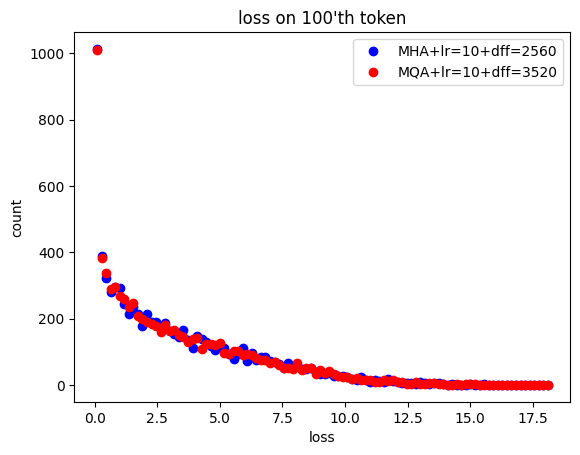

In [104]:
import numpy as np
import matplotlib.pyplot as plt

token_id = 100
bins = 100

data_mha = df_mha[f"{token_id}"]
data_mqa = df_mqa[f"{token_id}"]

# shared bins
all_data = np.concatenate([data_mha, data_mqa])
bins = np.histogram_bin_edges(all_data, bins=bins)

# histograms
cnt_mha, edges = np.histogram(data_mha, bins=bins)
cnt_mqa, _     = np.histogram(data_mqa, bins=bins)

centers = 0.5 * (edges[:-1] + edges[1:])

plt.plot(centers, cnt_mqa, 'o', color='blue', label=label1)
plt.plot(centers, cnt_mha, 'o', color='red', label=label2)

plt.xlabel("loss")
plt.ylabel("count")
plt.title(f"loss on {token_id}'th token")
plt.legend()
plt.show()


In [105]:
df_mha.max()

0       18.364435
1       19.697504
2       17.725044
3       19.266026
4       20.433304
          ...    
2042    24.662980
2043    18.582706
2044    17.632790
2045    17.838000
2046    17.737785
Length: 2047, dtype: float64

In [106]:
import numpy as np
import matplotlib.pyplot as plt

def _smooth_1d(x, window):
    if window <= 1:
        return x
    kernel = np.ones(window) / window
    return np.convolve(x, kernel, mode="valid")


def mean_drop_top_frac(df, frac):
    if frac <= 0:
        return df.mean(axis=0)
    q = 1.0 - frac
    return df.where(df.le(df.quantile(q, axis=0)), np.nan).mean(axis=0)


def plot_avg_loss_vs_token_id_with_diff(
    df1,
    df2,
    label1="model_1",
    label2="model_2",
    smoothing=1,
    head_trim=0,
    tail_trim=0,
    drop_outliers=0.0,
    ylim=None,
    figsize=(10, 6),
):
    """
    df1, df2: pandas DataFrames of shape (num_rows, seq_len)
    """

    avg1 = mean_drop_top_frac(df1, frac=drop_outliers).to_numpy()
    avg2 = mean_drop_top_frac(df2, frac=drop_outliers).to_numpy()


    # trim
    if tail_trim > 0:
        avg1 = avg1[head_trim:-tail_trim]
        avg2 = avg2[head_trim:-tail_trim]
    else:
        avg1 = avg1[head_trim:]
        avg2 = avg2[head_trim:]

    # smooth
    avg1 = _smooth_1d(avg1, smoothing)
    avg2 = _smooth_1d(avg2, smoothing)

    diff = avg1 - avg2

    token_ids = np.arange(len(avg1)) + head_trim

    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=figsize, sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )

    # top: both models
    ax_top.plot(token_ids, avg1, label=label1)
    ax_top.plot(token_ids, avg2, label=label2)
    ax_top.set_ylabel("Average loss")
    ax_top.legend()

    # bottom: difference
    ax_bot.set_title(f"{label1} - {label2}")
    ax_bot.axhline(0.0, linewidth=1)
    ax_bot.plot(token_ids, diff, label=f"{label1} − {label2}")
    ax_bot.set_xlabel("Token ID")
    ax_bot.set_ylabel("Δ loss")
    if ylim is not None:
        ax_bot.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


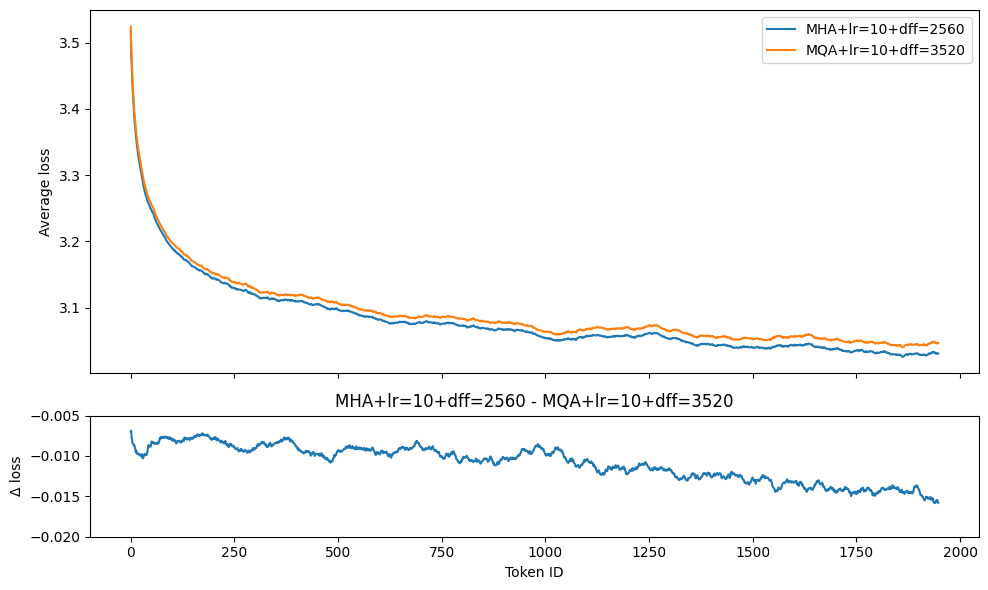

In [110]:
plot_avg_loss_vs_token_id_with_diff(
    df1=df_mha,
    df2=df_mqa,
    label1=label1,
    label2=label2,
    head_trim=0,
    tail_trim=0,
    smoothing=100,
    drop_outliers=0.0,
    ylim=(-0.02, -0.005),
    # ylim=(-0.035, -0.02),
    figsize=(10, 6),
)